<a href="https://colab.research.google.com/github/kumaramardeep342/Colab-Work/blob/main/AlexNet_CNN_handwritten_digits_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount the Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# AlexNet CNN handwritten digits Using Pytorch

## Problem Statement
MNIST ("Modified National Institute of Standards and Technology") Handwritten Digit Classification Dataset . In this notebook , goal is to correctly identify digits from a dataset of thousands of handwritten images.

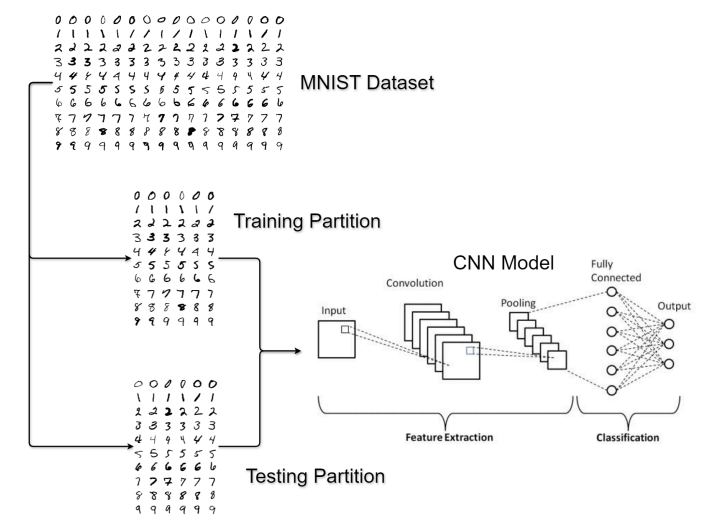

## Dataset Description
- **[MNIST Handwritten Digit Classification Dataset](http://yann.lecun.com/exdb/mnist/)**
- Black and White Images of handwritten digits - MNIST Data
- 28 pixels height and 28 pixels width, total of 784 pixels
- 60,000 training images and 10,000 testing images in dataset.
- Pixel-value 0 to 255
- 10 classes [0,1,2,3,4,5,6,7,8 and 9] - 6000 images per class in training

## Summary of the Notebook
- Install pytorch
- Import the required libraries - pytorch
- Read the dataset - Understanding - Preprocessing
- Split the dataset to training and testing[Already Done]
- Create a Model
- Check accuracy - validation
-  Tune Parameters
- Accuracy - validation

# AlexNet Model Classifying Handwritten digits using Pytorch

## Installing Pytorch

In [2]:
# !pip install torch torchvision torchaudio # install pytorch library
# torchvision (for computer vision), and torchaudio (for audio processing)

In [3]:
# verify installation
import torch
#check pytorch version
print(torch.__version__)

2.4.0+cu121


## Import the required libraries - pytorch

In [4]:
#enable table format
from google.colab import data_table
data_table.enable_dataframe_formatter()

#disable table format
# from google.colab import data_table
# data_table.disable_dataframe_formatter()

import pandas as pd  # for reading the dataset
import numpy as np  # for mathematical operations

import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  #for enchaned visulaization
%matplotlib inline

from torch import  nn,optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.autograd import Variable

## Preparing the Data

### Loading the Data

In [5]:
# Hyperparameters
batch_size = 16
torch.manual_seed(42) ##SEEDING FOR GETTING SAME OUTPUT

In [6]:
# MNIST Dataset
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))] # Normalizing the dataset
)

#The values (0.5,) and (0.5,) are the mean and standard deviation of the MNIST dataset, respectively.
#So, transforms.Normalize((0.5,), (0.5,)) is saying:
#Subtract 0.5 from every pixel value in the image,then divide every pixel value by 0.5
# transforms.Normalize((0.1307,), (0.3081,)) means Subtract 0.1307 from every pixel value in the image then  divide every pixel value by 0.3081

# Download and load the training data
train_dataset = datasets.MNIST(root = ' ./data',train = True , download  = True , transform = transform)
train_loader = DataLoader(train_dataset,batch_size = batch_size , shuffle = True)

# Download and load the testing data
test_dataset = datasets.MNIST(root = ' ./data',train = False , download  = True , transform = transform)
test_loader = DataLoader(test_dataset,batch_size = batch_size , shuffle = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16011466.92it/s]


Extracting  ./data/MNIST/raw/train-images-idx3-ubyte.gz to  ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 476510.71it/s]


Extracting  ./data/MNIST/raw/train-labels-idx1-ubyte.gz to  ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4432425.53it/s]


Extracting  ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to  ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5189465.75it/s]

Extracting  ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to  ./data/MNIST/raw



torch.Size([28, 28])
torch.Size([28, 28])


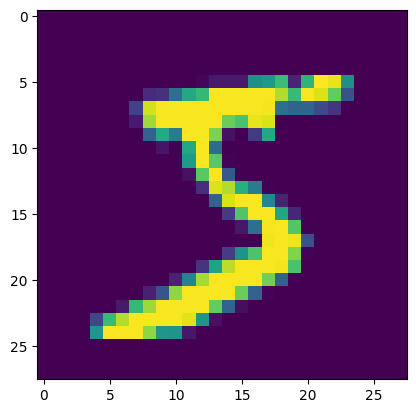

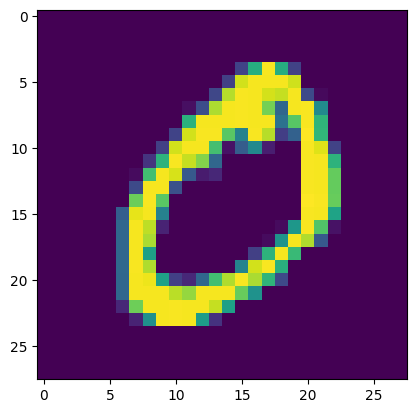

In [7]:
'''
Visualizing the Images
'''
show = 2
max_show = show
for i in train_dataset:
  current_image = i[0][0]
  plt.figure(max_show+1-show)
  plt.imshow(current_image)
  print(current_image.shape)
  show-=1
  if show==0:
    break

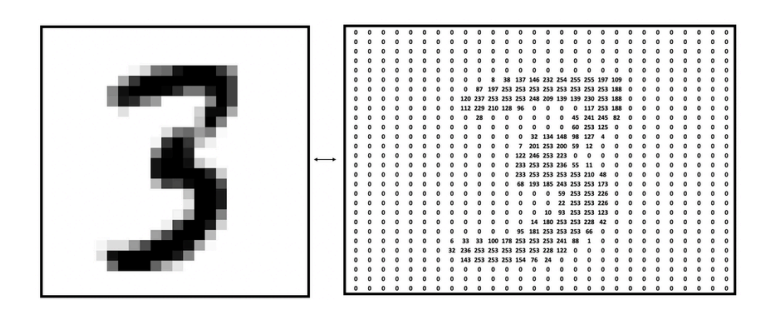

## Designing the Model - AlexNet

**The AlexNet Architecture**
![alt text](https://www.researchgate.net/publication/339756908/figure/fig5/AS:866265283457032@1583545146587/AlexNet-architecture-used-as-the-baseline-model-for-the-analysis-of-results-on-the.png)

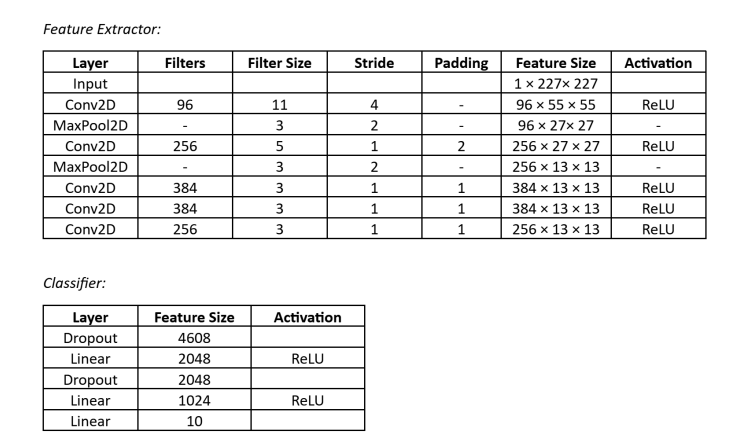

### Model Building

In [8]:
class AlexNet(nn.Module):
  def __init__ (self,num=10):
    super(AlexNet, self).__init__()
    self.feature = nn.Sequential(
        nn.Conv2d(1,256,kernel_size=5, stride=1, padding=2), #it skip first 2 layer and start from third layer.
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(256,384,kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,384,kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,256,kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256*13*13,2048), ## 256*13*13 -- is output in last Conv2D
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(2048,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,num)
    )
  def forward(self, x):
    x = self.feature(x)
    x = x.view(-1,256*13*13)
    x = self.classifier(x)
    return x

In [9]:
model = AlexNet()
if torch.cuda.is_available():
 print('GPU is available!')
 model.cuda()
summary(model, (1, 28, 28))

GPU is available!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           6,656
              ReLU-2          [-1, 256, 28, 28]               0
         MaxPool2d-3          [-1, 256, 13, 13]               0
            Conv2d-4          [-1, 384, 13, 13]         885,120
              ReLU-5          [-1, 384, 13, 13]               0
            Conv2d-6          [-1, 384, 13, 13]       1,327,488
              ReLU-7          [-1, 384, 13, 13]               0
            Conv2d-8          [-1, 256, 13, 13]         884,992
              ReLU-9          [-1, 256, 13, 13]               0
          Dropout-10                [-1, 43264]               0
           Linear-11                 [-1, 2048]      88,606,720
             ReLU-12                 [-1, 2048]               0
          Dropout-13                 [-1, 2048]               0
           Linear-14 

### Model Training & Evaluation

In [12]:
train_losses = []
test_losses = []

def train(self,optimizer,train_loader,epoch):
  model.train()
  for batch_idx ,(data,target) in enumerate(train_loader):
    if torch.cuda.is_available():
      data, target = data.cuda(), target.cuda()
    data,target  = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output,target)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('\rEpoch: {} {:.0f}%\t Loss: {:.6f}'.format(
      epoch,100. * batch_idx / len(train_loader), loss.item()), end='')


def test(model,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
     if torch.cuda.is_available():
      data, target = data.cuda(), target.cuda()
     with torch.no_grad():
      data, target = Variable(data), Variable(target)

     output = model(data)
     test_loss += F.cross_entropy(output, target, reduction='sum').item()#size_averag
     pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probab
     correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  acc=100. * float(correct.to(torch.device('cpu')).numpy())
  print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
  test_loss, acc / len(test_loader.dataset)))
  test_accuracy = (acc / len(test_loader.dataset))
  return test_accuracy

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 2
for epoch in range(1, epochs+1):
 train(model,optimizer,train_loader,epoch)
 accuracy = test(model,test_loader)
 # print(f'----------------')
 # print(f'Epoch: {epoch+1}')
 # print(f'Accuracy: {accuracy}')


Epoch: 1 100%	 Loss: 0.034101
Test result: Average loss: 0.0605, Accuracy: 98.0200%

Epoch: 2 100%	 Loss: 0.127480
Test result: Average loss: 0.0419, Accuracy: 98.6400%



### Visualization Predicted Images

Correctly Classified Examples:


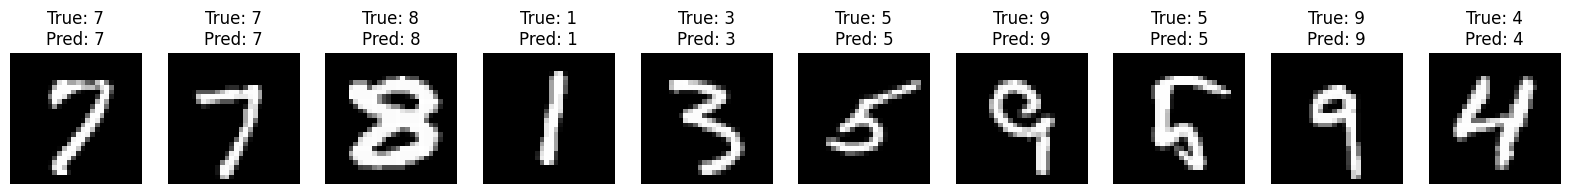

Incorrectly Classified Examples:


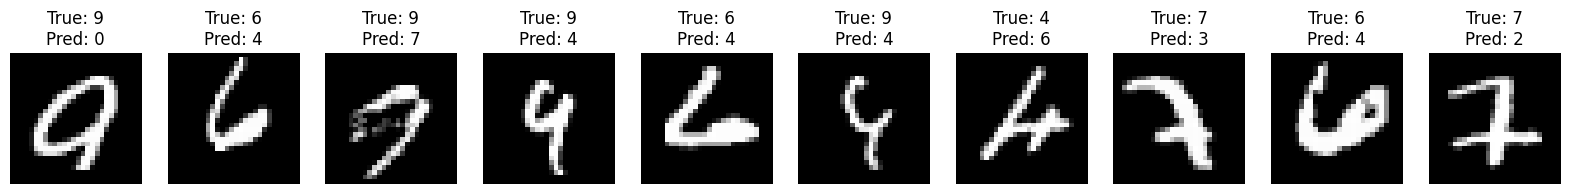

In [16]:
# Function to display a row of images with their predicted and true labels
def show_images(images, labels, preds, title):
  fig, axes = plt.subplots(1, 10, figsize=(20, 2)) # Create a row of 10 subplots
  for i in range(10):
    # Move the tensor to CPU and convert it to a NumPy array
    axes[i].imshow(images[i].cpu().squeeze().numpy(), cmap='gray') # Display the image
    axes[i].set_title(f'True: {labels[i]}\nPred: {preds[i]}')
    axes[i].axis('off') # Hide axis
  fig.suptitle(title, fontsize=16)
  plt.show()

# Set the model to evaluation mode
model.eval()

# Check if CUDA is available and move the model to the GPU if it is
if torch.cuda.is_available():
    model.cuda()

# Collecting correctly and incorrectly classified images
correct_examples = []
incorrect_examples = []

with torch.no_grad():
  for images, labels in test_loader:
    if torch.cuda.is_available():
      images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    for img, label, pred in zip(images, labels, predicted):
      # Check if the prediction is correct or incorrect
      if label == pred and len(correct_examples) < 10:
        correct_examples.append((img, label.item(), pred.item()))
      elif label != pred and len(incorrect_examples) < 10:
        incorrect_examples.append((img, label.item(), pred.item()))

      # Break if we have collected enough examples
      if len(correct_examples) >= 10 and len(incorrect_examples) >= 10:
        break
    if len(correct_examples) >= 10 and len(incorrect_examples) >= 10:
      break

# Prepare data for visualization
correct_images = [img for img, _, _ in correct_examples]
correct_labels = [label for _, label, _ in correct_examples]
correct_preds = [pred for _, _, pred in correct_examples]
incorrect_images = [img for img, _, _ in incorrect_examples]
incorrect_labels = [label for _, label, _ in incorrect_examples]
incorrect_preds = [pred for _, _, pred in incorrect_examples]
# Visualizing Correctly Classified Images
print("Correctly Classified Examples:")
show_images(correct_images, correct_labels, correct_preds, title='')
# Visualizing Incorrectly Classified Images
print("Incorrectly Classified Examples:")
show_images(incorrect_images, incorrect_labels, incorrect_preds, title='')

# References
- https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5
- Wikipedia
- Research Gate
- IITKGP AI4ICPS I Hub Foundation